In [10]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from utils import load_file,evaluate

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [11]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5","1_0","1_1","1_2","1_3","1_4","1_5","2_0","2_1","2_2","2_3","2_4","2_5","3_0","3_1","3_2","3_3","3_4","3_5"]

In [12]:
fed_learning_all_losses = pd.read_csv("losses/fed_learning_stats_64.csv")

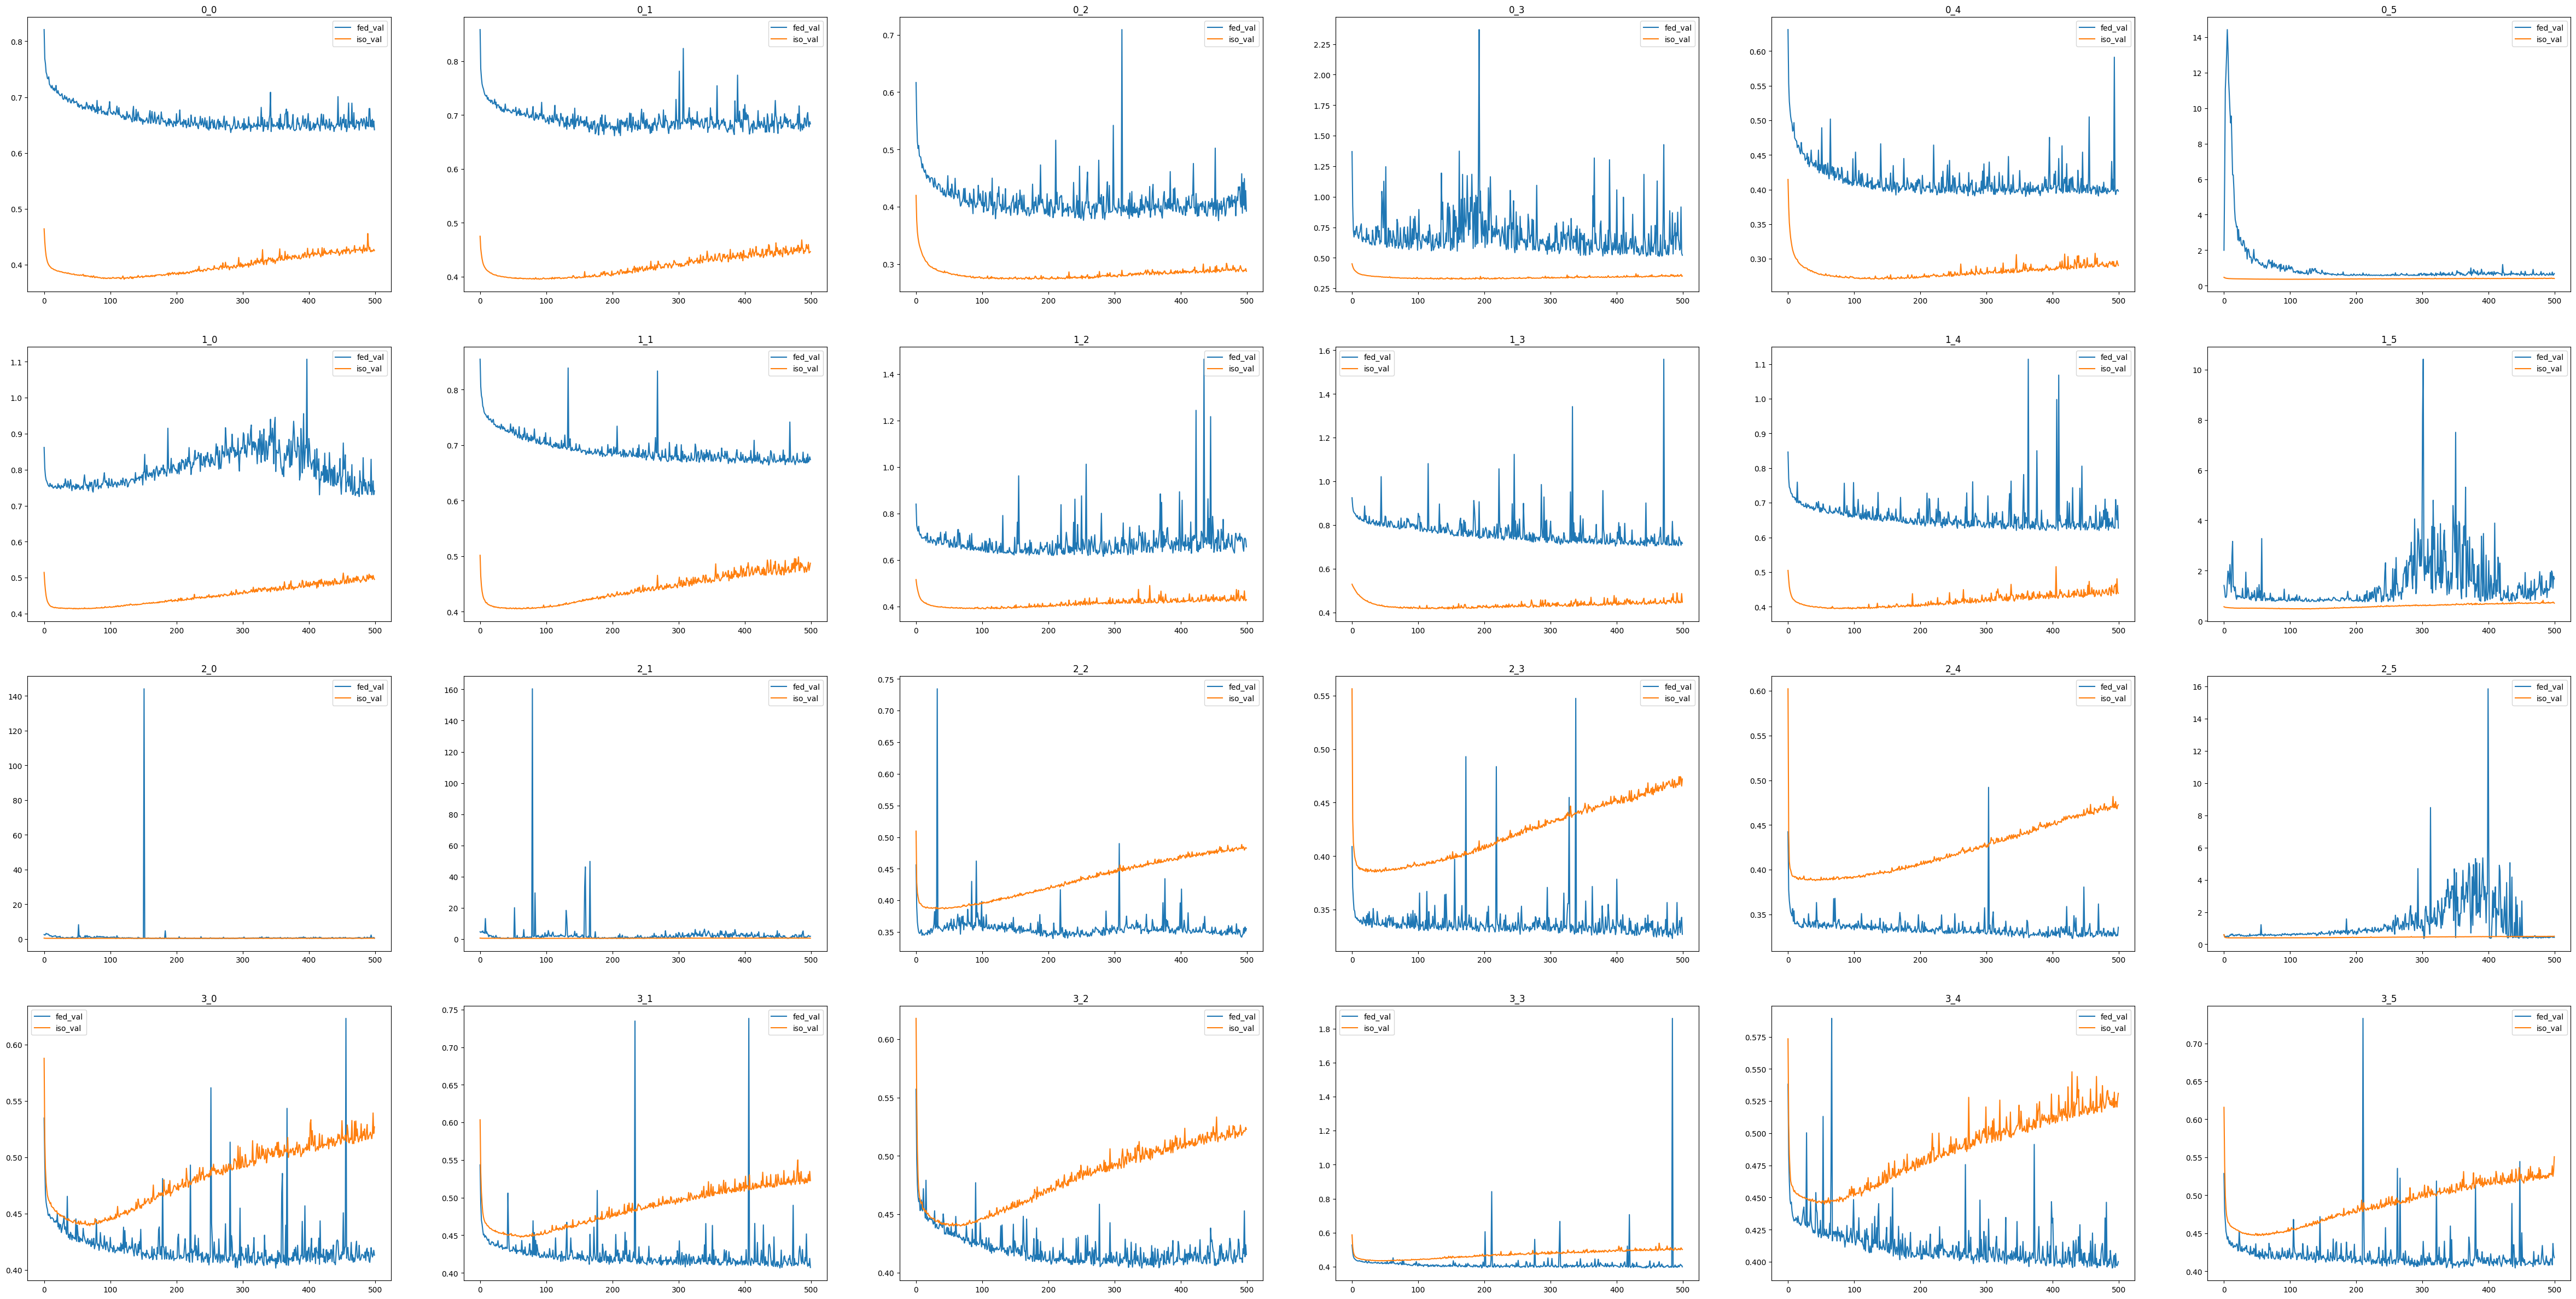

In [13]:
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(60, 30))
for client in client_ids:
    plot_id = client.split("_")
    fed_losses = fed_learning_all_losses.loc[fed_learning_all_losses['client_id'] == client].reset_index().drop(columns=['index','training_round','client_id','fed_train'])
    fed_losses = fed_losses.rename(columns={"validation_loss": "fed_val"})
    iso_losses = pd.read_csv("losses/batch64_client_"+str(client)+".csv").drop(columns=["iso_train"])
    df = pd.concat([fed_losses, iso_losses], axis=1)
    df.plot(ax=axes[int(plot_id[0])][int(plot_id[1])],title=client)

In [4]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/_fedl_global_500.pth'))

<All keys matched successfully>

In [ ]:
eval_list = []
for client in client_ids:
    
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "checkpt/isolated/batch64_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    _, _ , isolated_mae = evaluate(isolated_model, val_loader, loss_fn)
    _, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
    
    eval_dict = {"client_id":client, "Isolated Model MAE": round(isolated_mae, 4), "Federated Model MAE" :round(global_mae, 4)}
    eval_list.append(eval_dict)
    
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

In [ ]:
ax = eval_df.plot.bar(x="clients",figsize=(20, 10))
ax.set_ylabel("Mean Absolute Error for Validation",fontdict={'fontsize':13})
ax.set_xlabel("Client IDs",fontdict={'fontsize':13})
ax.legend(fontsize=15, loc="upper right")

In [ ]:
ben_list = []
for index, row in eval_df.iterrows():
    ben_list.append(round(row['Isolated Model MAE']-row['Federated Model MAE'],4))
eval_df["Benefict"] = ben_list

In [ ]:
eval_df.plot.bar(x="clients",y="Benefict", figsize=(8, 4))

In [ ]:
def influence(global_model, influenced_model):
    eval_list = []
    for client in client_ids:

        val_data_path =  "testpt/"+str(client)+".pt"
        val_set = torch.load(val_data_path)
        val_loader = DataLoader(val_set, batch_size, shuffle = True)

        _, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
        _, _ , influenced_mae = evaluate(influenced_model, val_loader, loss_fn)

        eval_dict = {"client_id":client, "global_mae": round(global_mae, 4), "influenced_mae" :round(influenced_mae, 4)}
        eval_list.append(eval_dict)

    eval_df = pd.DataFrame.from_dict(eval_list)
    influence = round(eval_df["global_mae"].sum() - eval_df["influenced_mae"].sum() , 4)
    return eval_df, influence

In [ ]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5"]
inf_val = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('checkpt/influence/' + str(client)+ '_fedl_global_500.pth'))
    df, inf = influence(global_model,model)
    inf_val.append(inf)
    df.to_csv("influence2_"+str(client) + ".csv", index=False)
data = {"client id": client_ids, "inf_val": inf_val}
data = pd.DataFrame(data)
#data.to_csv("influence2.csv")

In [ ]:
ax = inf_df_0_3.plot.bar(x="client_id",figsize=(20, 10),color={"global_mae": "darkorange", "influenced_mae": "teal"},
                   title='MAE comparison in global model (with and without client 0_5)')
ax.set_ylabel("mean absolute error for validation")

In [ ]:
def cosin_similarity(x, y):
    # define a method to measure cosine similarity
    try:
        cos = torch.nn.CosineSimilarity(dim=1)
        return cos(x, y)
    except Exception as err:
        print(err)


sim = cosin_similarity(global_model.track_layers["layer_1"].weight.data, influenced_model.track_layers["layer_1"].weight.data)

In [5]:
from utils import calculate_hessian
from utils import calculate_hessian_flattened

val_dataset = torch.load("trainpt/0_0.pt")
validation_data_loader = DataLoader(val_dataset, batch_size, shuffle=True)

In [9]:
hessian_mat, time1 = calculate_hessian_flattened(global_model,loss_fn,validation_data_loader)

tensor(0.4222, grad_fn=<DivBackward0>)
Calculation time of Gradients 0.016606807708740234
Calculation time of Hessian 578.516891002655


In [17]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/_fedl_global_500.pth'))

def hessian(client):
    
    val_dataset = torch.load("trainpt/"+ str(client)+".pt")
    validation_data_loader = DataLoader(val_dataset, batch_size, shuffle=True)
    
    isolated_model = ShallowNN(features)
    isolated_model_path = "checkpt/isolated/batch64_client_"+str(client)+".pth"
    isolated_model.load_state_dict(torch.load(isolated_model_path))
                                              
    fed_hessian_mat , _  = calculate_hessian_flattened(global_model,loss_fn,validation_data_loader)
    iso_hessian_mat , _ = calculate_hessian_flattened(isolated_model,loss_fn,validation_data_loader)
    
    return fed_hessian_mat, iso_hessian_mat

In [18]:
hessian("0_0")

tensor(0.4225, grad_fn=<DivBackward0>)
Calculation time of Gradients 0.017652034759521484
Calculation time of Hessian 549.0477590560913
tensor(0.1974, grad_fn=<DivBackward0>)
Calculation time of Gradients 0.017190933227539062
Calculation time of Hessian 562.8721537590027


(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.1257e-18,
           2.5710e-19,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.7690e-04,
           6.6694e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.4521e-03,
           8.2353e-04,  0.0000e+00],
         ...,
         [ 1.1257e-18, -8.7690e-04, -1.4521e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.5710e-19,  6.6694e-04,  8.2353e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.2150e-18,
          -9.4095e-20,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.2510e-03,
           1.7567e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  8.6961e-03,
           1.7740e-04,  0.0000e+00],
         ...,
         [ 5.2150e-18,  6

In [ ]:
for client in client_ids:
    fed_hessian_mat , iso_hessian_mat = hessian(client)
    

In [ ]:
def cosin_similarity(x, y):
    # define a method to measure cosine similarity
    try:
        cos = torch.nn.CosineSimilarity(dim=1)
        return cos(x, y)
    except Exception as err:
        print(err)

In [ ]:
cosin_similarity(hessian_mat,hessian_mat1)

In [ ]:
isolated_model_path = "checkpt/isolated/batch64_client_0_5.pth"
isolated_model =  ShallowNN(features)
isolated_model.load_state_dict(torch.load(isolated_model_path))

In [ ]:
from utils import calculate_hessian
from utils import calculate_hessian_flattened

val_dataset = torch.load("trainpt/0_0.pt")
validation_data_loader = DataLoader(val_dataset, batch_size, shuffle=True)

def influence(model,influenced_model, dataloader) -> tuple:
    model.eval()
    influenced_model.eval()
    
    total_influence = 0
    for _, (x, y) in enumerate(dataloader):
        batch_inf = abs(model(x).sum() - influenced_model(x).sum())/len(x)
        total_influence += batch_inf
    influence = total_influence/len(dataloader)

    return influence

In [ ]:
from utils import calculate_hessian
from utils import calculate_hessian_flattened

val_dataset = torch.load("trainpt/0_0.pt")
validation_data_loader = DataLoader(val_dataset, batch_size, shuffle=True)

def influence(model,influenced_model, dataloader) -> tuple:
    model.eval()
    influenced_model.eval()
    
    total_influence = 0
    for _, (x, y) in enumerate(dataloader):
        batch_inf = abs(model(x).sum() - influenced_model(x).sum())/len(x)
        total_influence += batch_inf
    influence = total_influence/len(dataloader)

    return influence

In [ ]:
influence(global_model,isolated_model,validation_data_loader)

In [ ]:
df